# Imports

In [277]:
import wbgapi as wb
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from yellowbrick.regressor import residuals_plot,ResidualsPlot
from yellowbrick.regressor import prediction_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
import pickle


# Functions

In [278]:
def read_data(codes):
    worldbank_data = wb.data.DataFrame(codes, 
                                       ['DEU', 'AUS', 'CAN', 'USA', 'FRA', 'ITA', 'JPN', 'GBR', 'ZAF', 'SAU', 'ARG', 'BRA', 'CHN', 'KOR', 'IND', 'IDN', 'MEX', 'RUS', 'TUR'],
                                      range(1990, 2020, 1))
    return worldbank_data

In [320]:
def get_data(data):
    dict_data={}
    
    for index, row in data.items():
        if len(row)>19:
            for index2, row2 in row.items():
                if not dict_data.get(index2[1]):
                    dict_data[index2[1]]=[]
                dict_data.get(index2[1]).append(row2)
        else:
            for index2, row2 in row.items():
                if not dict_data.get("coluna"):
                    dict_data["coluna"]=[]
                dict_data.get("coluna").append(row2)
    return pd.DataFrame(dict_data)

In [291]:
def get_model(input, output):
    
    data_input = get_data(input)
    data_output = get_data(output)
    
    normalizer = MinMaxScaler(feature_range = (-1, 1))
    
    x = sc.fit_transform(data_input)
    y = sc.fit_transform(data_output)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, 
                                                    random_state=42)
    
    model = MultiOutputRegressor(XGBRegressor(max_depth=3, n_estimators=100, n_jobs=3,
                           objective='reg:squarederror',
                           random_state=42, learning_rate=0.05))
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) # Predictions
    y_true = y_test
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    print("\nRMSE: ", np.round(RMSE, 2))
    print()
    print("R-Squared: ", np.round(R_squared, 2))
    return [model, sc]

In [328]:
def save(nome, model, normalizer):
    with open(f'models/normalizer_{nome}.pkl','wb') as f:
        pickle.dump(normalizer,f)
    with open(f'models/model_{nome}.pkl','wb') as f:
        pickle.dump(model,f)
    print('salvo')

## Agricultura e desenvolvimento rural

In [292]:
inputs_agricultura= ['NV.AGR.TOTL.CD']

In [282]:
df_inputs_agricultura = read_data(inputs_agricultura)

In [284]:
df_inputs_agricultura.fillna(df_inputs_agricultura.mean(), inplace=True)
# df_inputs_agricultura = df_inputs_agricultura.groupby(level=0).sum()

In [285]:
outputs_agricultura = ['SL.AGR.EMPL.ZS','SP.RUR.TOTL.ZS','AG.PRD.FOOD.XD']

In [286]:
df_outputs_agricultura = read_data(outputs_agricultura)

In [287]:
df_outputs_agricultura[df_outputs_agricultura.isnull().all(axis=1)]

,,YR1990,YR1991,YR1992,YR1993,YR1994,YR1995,YR1996,YR1997,YR1998,YR1999,...,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
economy,series,,,,,,,,,,,,,,,,,,,,,


In [324]:
model_agricultura, normalizer_agricultura = get_model(df_inputs_agricultura,df_outputs_agricultura)


RMSE:  0.36

R-Squared:  0.96


In [329]:
save('agricultura',model_agricultura,normalizer_agricultura)

salvo


In [288]:
df_outputs_agricultura.fillna(df_outputs_agricultura.mean(), inplace=True)
# df_outputs_agricultura = df_outputs_agricultura.groupby(level=0).sum()

## Educação

In [11]:
inputs_educacao=["SE.XPD.PRIM.ZS", "SE.XPD.SECO.ZS", "SE.XPD.TERT.ZS", "SE.XPD.TOTL.GB.ZS"]

In [12]:
df_inputs_educacao = read_data(inputs_educacao)

In [13]:
df_inputs_educacao[df_inputs_educacao.isnull().all(axis=1)]

YR1990  YR1991  YR1992  YR1993  YR1994  YR1995  \
economy series                                                              
CAN     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
KOR     SE.XPD.TOTL.GB.ZS     NaN     NaN     NaN     NaN     NaN     NaN   
RUS     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
        SE.XPD.SECO.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
SAU     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
        SE.XPD.SECO.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
USA     SE.XPD.TOTL.GB.ZS     NaN     NaN     NaN     NaN     NaN     NaN   

                           YR1996  YR1997  YR1998  YR1999  ...  YR2010  \
economy series                                             ...           
CAN     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN  ...     NaN   
KOR     SE.XPD.TOTL.GB.ZS     NaN     NaN     NaN     NaN  ...     NaN   
RUS     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN  ...     NaN   
        SE.XPD.SECO.ZS        NaN     NaN     NaN     NaN  ...     NaN   
SAU     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN  ...     NaN   
        SE.XPD.SECO.ZS        NaN     NaN     NaN     NaN  ...     NaN   
USA     SE.XPD.TOTL.GB.ZS     NaN     NaN     NaN     NaN  ...     NaN   

                           YR2011  YR2012  YR2013  YR2014  YR2015  YR2016  \
economy series                                                              
CAN     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
KOR     SE.XPD.TOTL.GB.ZS     NaN     NaN     NaN     NaN     NaN     NaN   
RUS     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
        SE.XPD.SECO.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
SAU     SE.XPD.PRIM.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
        SE.XPD.SECO.ZS        NaN     NaN     NaN     NaN     NaN     NaN   
USA     SE.XPD.TOTL.GB.ZS     NaN     NaN     NaN     NaN     NaN     NaN   

                           YR2017  YR2018  YR2019  
economy series                                     
CAN     SE.XPD.PRIM.ZS        NaN     NaN     NaN  
KOR     SE.XPD.TOTL.GB.ZS     NaN     NaN     NaN  
RUS     SE.XPD.PRIM.ZS        NaN     NaN     NaN  
        SE.XPD.SECO.ZS        NaN     NaN     NaN  
SAU     SE.XPD.PRIM.ZS        NaN     NaN     NaN  
        SE.XPD.SECO.ZS        NaN     NaN     NaN  
USA     SE.XPD.TOTL.GB.ZS     NaN     NaN     NaN  

[7 rows x 30 columns]

In [14]:
df_inputs_educacao.fillna(df_inputs_educacao.mean(), inplace=True)
# df_inputs_educacao = df_inputs_educacao.groupby(level=0).sum()

In [404]:
outputs_educacao = ["SE.ADT.LITR.ZS","SE.ADT.1524.LT.ZS","SE.PRM.CMPT.ZS", 'SE.SEC.CMPT.LO.ZS','SE.SEC.UNER.LO.ZS','SE.PRM.UNER.ZS']
df_outputs_educacao = read_data(outputs_educacao)
df_outputs_educacao.fillna(df_outputs_educacao.mean(), inplace=True)

In [405]:
# df_outputs_educacao.fillna(df_outputs_educacao.mean(), inplace=True)
# df_outputs_educacao = df_outputs_educacao.groupby(level=0).sum()

In [406]:
ouputs_negative_educacao = ['SE.SEC.CMPT.LO.ZS','SE.SEC.UNER.LO.ZS','SE.PRM.UNER.ZS']
# df_ouputs_negative_educacao = read_data(ouputs_negative_educacao)
# df_ouputs_negative_educacao.fillna(df_ouputs_negative_educacao.mean(), inplace=True)
# df_ouputs_negative_educacao = df_ouputs_negative_educacao * -1
# pd.concat([df_outputs_educacao, df_ouputs_negative_educacao])

In [407]:
df_outputs_educacao

YR1990     YR1991     YR1992     YR1993  \
economy series                                                          
ARG     SE.ADT.1524.LT.ZS  57.697009  98.304642  52.413408  49.270402   
        SE.ADT.LITR.ZS     57.697009  96.040718  52.413408  49.270402   
        SE.PRM.CMPT.ZS     57.697009  50.125052  52.413408  49.270402   
        SE.PRM.UNER.ZS     57.697009   3.824100  52.413408  49.270402   
        SE.SEC.CMPT.LO.ZS  57.697009  50.125052  52.413408  49.270402   
...                              ...        ...        ...        ...   
ZAF     SE.ADT.LITR.ZS     57.697009  50.125052  52.413408  49.270402   
        SE.PRM.CMPT.ZS     57.697009  77.067719  52.413408  49.270402   
        SE.PRM.UNER.ZS     57.697009  12.885810  52.413408  49.270402   
        SE.SEC.CMPT.LO.ZS  57.697009  56.152618  52.413408  49.270402   
        SE.SEC.UNER.LO.ZS  57.697009  50.125052  52.413408  49.270402   

                              YR1994     YR1995     YR1996     YR1997  \
economy series                                                          
ARG     SE.ADT.1524.LT.ZS  49.455680  46.976121  46.996034  48.144630   
        SE.ADT.LITR.ZS     49.455680  46.976121  46.996034  48.144630   
        SE.PRM.CMPT.ZS     98.577599  46.976121  92.963257  91.528763   
        SE.PRM.UNER.ZS     49.455680  46.976121  46.996034   0.000000   
        SE.SEC.CMPT.LO.ZS  49.455680  46.976121  46.996034  48.144630   
...                              ...        ...        ...        ...   
ZAF     SE.ADT.LITR.ZS     49.455680  46.976121  82.402100  48.144630   
        SE.PRM.CMPT.ZS     49.455680  46.976121  46.996034  48.144630   
        SE.PRM.UNER.ZS     10.883730  10.261400  46.996034  48.144630   
        SE.SEC.CMPT.LO.ZS  49.455680  46.976121  46.996034  48.144630   
        SE.SEC.UNER.LO.ZS  13.375800  46.976121  46.996034  48.144630   

                              YR1998     YR1999  ...      YR2010      YR2011  \
economy series                                   ...                           
ARG     SE.ADT.1524.LT.ZS  35.856585  41.947214  ...   99.298637   99.628242   
        SE.ADT.LITR.ZS     35.856585  41.947214  ...   98.954971   99.108330   
        SE.PRM.CMPT.ZS     99.151718  97.202042  ...  103.567413  103.887711   
        SE.PRM.UNER.ZS      0.265700   0.165470  ...    0.603730    0.565900   
        SE.SEC.CMPT.LO.ZS  35.856585  80.332611  ...   81.547379   85.269440   
...                              ...        ...  ...         ...         ...   
ZAF     SE.ADT.LITR.ZS     35.856585  41.947214  ...   92.877319   93.102142   
        SE.PRM.CMPT.ZS     84.870483  79.950081  ...   57.337221   58.558475   
        SE.PRM.UNER.ZS      9.817430   8.657320  ...   57.337221   58.558475   
        SE.SEC.CMPT.LO.ZS  35.856585  74.023102  ...   57.337221   58.558475   
        SE.SEC.UNER.LO.ZS  35.856585  13.118210  ...   57.337221   58.558475   

                               YR2012      YR2013      YR2014      YR2015  \
economy series                                                              
ARG     SE.ADT.1524.LT.ZS   99.375870   99.551323   99.296707   99.559700   
        SE.ADT.LITR.ZS      99.105232   99.121948   98.993889   99.179962   
        SE.PRM.CMPT.ZS     103.352249  101.645012  103.106438  102.973740   
        SE.PRM.UNER.ZS       0.571760    0.408090    0.098040    0.056300   
        SE.SEC.CMPT.LO.ZS   86.210251   88.456207   88.916321   90.115860   
...                               ...         ...         ...         ...   
ZAF     SE.ADT.LITR.ZS      93.729469   48.267920   94.139900   94.367920   
        SE.PRM.CMPT.ZS      49.989132   48.267920   53.484998   90.110489   
        SE.PRM.UNER.ZS      49.989132   48.267920   53.484998    4.354490   
        SE.SEC.CMPT.LO.ZS   49.989132   48.267920   53.484998   52.729689   
        SE.SEC.UNER.LO.ZS   49.989132   48.267920   53.484998   52.729689   

                               YR2016     YR2017     YR2018     YR2019  
economy series

In [445]:
def to_negative(row):
    print(row.index[0][1])
    if row.index[0][1] in ouputs_negative_educacao:
        print(row.index[0][1])
        row = row * -1
    return row

In [446]:
ouputs_negative_educacao

['SE.SEC.CMPT.LO.ZS', 'SE.SEC.UNER.LO.ZS', 'SE.PRM.UNER.ZS']

In [449]:
# df_outputs_educacao.apply(to_negative, axis=0)

In [450]:
# df_outputs_educacao.min()

In [21]:
df_ouputs_negative_educacao.fillna(df_ouputs_negative_educacao.mean(), inplace=True)
# df_ouputs_negative_educacao = df_ouputs_negative_educacao.groupby(level=0).sum()

## Mudanças climáticas e meio ambiente

In [462]:
inputs_ambiente = ['EN.ATM.METH.AG.ZS','EN.ATM.METH.AG.KT.CE','EN.ATM.NOXE.AG.ZS','EN.ATM.CO2E.KD.GD']

In [463]:
df_inputs_ambiente = read_data(inputs_ambiente)
df_inputs_ambiente.fillna(df_inputs_ambiente.mean(), inplace=True)

In [24]:
# df_inputs_ambiente[df_inputs_ambiente.isnull().all(axis=1)]

,,YR1990,YR1991,YR1992,YR1993,YR1994,YR1995,YR1996,YR1997,YR1998,YR1999,...,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
economy,series,,,,,,,,,,,,,,,,,,,,,


In [464]:
# df_inputs_ambiente.fillna(df_inputs_ambiente.mean(), inplace=True)
# df_inputs_ambiente = df_inputs_ambiente.groupby(level=0).sum()
df_inputs_ambiente

YR1990        YR1991        YR1992  \
economy series                                                           
ARG     EN.ATM.CO2E.KD.GD         0.375596      0.363054      0.342840   
        EN.ATM.METH.AG.KT.CE  84680.000000  83650.000000  84630.000000   
        EN.ATM.METH.AG.ZS        80.000000     79.169033     78.747557   
        EN.ATM.NOXE.AG.ZS        95.860321     95.675523     95.595568   
AUS     EN.ATM.CO2E.KD.GD         0.417434      0.420866      0.424918   
...                                    ...           ...           ...   
USA     EN.ATM.NOXE.AG.ZS        64.509143     64.108190     64.398272   
ZAF     EN.ATM.CO2E.KD.GD         1.463442      1.446677      1.456857   
        EN.ATM.METH.AG.KT.CE  17710.000000  17890.000000  17670.000000   
        EN.ATM.METH.AG.ZS        39.806698     39.570891     38.809576   
        EN.ATM.NOXE.AG.ZS        78.020224     77.227201     75.946667   

                                    YR1993        YR1994        YR1995  \
economy series                                                           
ARG     EN.ATM.CO2E.KD.GD         0.327698      0.317380      0.326675   
        EN.ATM.METH.AG.KT.CE  83270.000000  83900.000000  83240.000000   
        EN.ATM.METH.AG.ZS        77.851533     77.377110     76.479236   
        EN.ATM.NOXE.AG.ZS        95.367771     95.358995     95.098039   
AUS     EN.ATM.CO2E.KD.GD         0.414546      0.407900      0.407400   
...                                    ...           ...           ...   
USA     EN.ATM.NOXE.AG.ZS        63.512739     63.573361     62.004474   
ZAF     EN.ATM.CO2E.KD.GD         1.484962      1.471499      1.496235   
        EN.ATM.METH.AG.KT.CE  17090.000000  16670.000000  16690.000000   
        EN.ATM.METH.AG.ZS        37.568696     36.557018     38.052896   
        EN.ATM.NOXE.AG.ZS        75.584416     74.451411     74.323607   

                                    YR1996        YR1997        YR1998  \
economy series                                                           
ARG     EN.ATM.CO2E.KD.GD         0.344246      0.320331      0.322628   
        EN.ATM.METH.AG.KT.CE  80600.000000  79840.000000  77140.000000   
        EN.ATM.METH.AG.ZS        75.144509     74.228338     72.945626   
        EN.ATM.NOXE.AG.ZS        94.921664     94.707298     94.573434   
AUS     EN.ATM.CO2E.KD.GD         0.406545      0.400406      0.408956   
...                                    ...           ...           ...   
USA     EN.ATM.NOXE.AG.ZS        62.222302     63.419265     64.412996   
ZAF     EN.ATM.CO2E.KD.GD         1.487709      1.529077      1.561439   
        EN.ATM.METH.AG.KT.CE  17310.000000  17610.000000  18060.000000   
        EN.ATM.METH.AG.ZS        40.586166     42.846715     45.479728   
        EN.ATM.NOXE.AG.ZS        75.940997     76.563294     77.284200   

                                    YR1999  ...        YR2010        YR2011  \
economy series                              ...                               
ARG     EN.ATM.CO2E.KD.GD         0.336491  ...      0.304195      0.302531   
        EN.ATM.METH.AG.KT.CE  79230.000000  ...  77640.000000  76880.000000   
        EN.ATM.METH.AG.ZS        72.875276  ...  50872.645009  51940.008955   
        EN.ATM.NOXE.AG.ZS        94.533762  ...  50872.645009  51940.008955   
AUS     EN.ATM.CO2E.KD.GD         0.395600  ...      0.327982      0.318793   
...                                    ...  ...           ...           ...   
USA     EN.ATM.NOXE.AG.ZS        64.902958  ...  50872.645009  51940.008955   
ZAF     EN.ATM.CO2E.KD.GD         1.432070  ...      1.492441      1.390634   
        EN.ATM.METH.AG.KT.CE  17910.000000  ...  17280.000000  17100.000000   
        EN.ATM.METH.AG.ZS        47.481442  ...  50872.645009  51940.008955   
        EN.ATM.NOXE.AG.ZS        77.618804  ...  50872.645009  51940.008955   

                                    YR2012        YR2013        YR2014  \
economy series                               

In [469]:
outputs_ambiente = ["EG.ELC.ACCS.ZS","EG.ELC.HYRO.ZS","EG.ELC.RNWX.ZS"]

In [470]:
df_outputs_ambiente = read_data(outputs_ambiente)

In [471]:
# df_outputs_ambiente[df_outputs_ambiente.isnull().all(axis=1)]

In [472]:
df_outputs_ambiente.fillna(df_outputs_ambiente.mean(), inplace=True)
# df_outputs_ambiente = df_outputs_ambiente.groupby(level=0).sum()
df_outputs_ambiente

YR1990      YR1991      YR1992      YR1993  \
economy series                                                           
ARG     EG.ELC.ACCS.ZS   92.154800   92.492188   92.829453   93.166046   
        EG.ELC.HYRO.ZS   35.230587   30.250079   34.687998   38.760231   
        EG.ELC.RNWX.ZS    0.210879    0.186487    0.182531    0.173769   
AUS     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS    9.169924   10.106940    9.645815   10.131956   
        EG.ELC.RNWX.ZS    0.486107    0.491261    0.421050    0.417187   
BRA     EG.ELC.ACCS.ZS   87.475116   90.606544   88.803833   89.999927   
        EG.ELC.HYRO.ZS   92.768635   92.919527   92.392815   93.288647   
        EG.ELC.RNWX.ZS    1.731883    1.706225    2.026625    1.966060   
CAN     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS   61.558457   60.626872   60.809297   60.805424   
        EG.ELC.RNWX.ZS    0.820262    0.783541    0.869918    0.916904   
CHN     EG.ELC.ACCS.ZS   33.180284   33.317747   34.937557   35.260442   
        EG.ELC.HYRO.ZS   20.396995   18.460063   17.567311   18.108204   
        EG.ELC.RNWX.ZS    0.010945    0.011068    0.017372    0.017056   
DEU     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS    3.181959    2.779074    3.259867    3.421712   
        EG.ELC.RNWX.ZS    0.304391    0.389679    0.438097    0.505659   
FRA     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS   12.911344   12.754754   14.990076   13.817619   
        EG.ELC.RNWX.ZS    0.458534    0.465444    0.463902    0.420735   
GBR     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS    1.638684    1.438921    1.700663    1.337416   
        EG.ELC.RNWX.ZS    0.190084    0.217518    0.304998    0.440210   
IDN     EG.ELC.ACCS.ZS   33.180284   48.900000   66.696564   55.430000   
        EG.ELC.HYRO.ZS   17.473291   17.747724   21.227085   17.365639   
        EG.ELC.RNWX.ZS    3.443842    2.809320    2.611230    2.409692   
IND     EG.ELC.ACCS.ZS   33.180284   33.317747   34.937557   50.900000   
        EG.ELC.HYRO.ZS   24.478362   22.795186   20.726553   19.531378   
        EG.ELC.RNWX.ZS    0.010932    0.012216    0.026099    0.027436   
ITA     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS   14.837647   19.335863   18.951982   18.851396   
        EG.ELC.RNWX.ZS    1.538375    1.510650    1.601937    1.728367   
JPN     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS    9.958318   10.569400    8.882103   10.210591   
        EG.ELC.RNWX.ZS    1.296420    1.287335    1.280784    1.243937   
KOR     EG.ELC.ACCS.ZS   99.882843   99.912674   99.942215   99.969437   
        EG.ELC.HYRO.ZS    6.036765    3.078010    2.489470    2.955221   
        EG.ELC.RNWX.ZS    0.000949    0.000883    0.001608    0.002097   
MEX     EG.ELC.ACCS.ZS   33.180284   33.317747   93.145981   95.448463   
        EG.ELC.HYRO.ZS   20.268135   16.997744   19.696833   19.336935   
        EG.ELC.RNWX.ZS    4.425184    5.390838    5.958725    6.059422   
RUS     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS   15.332134   15.688055   17.040309   18.143626   
        EG.ELC.RNWX.ZS    0.006007    0.006085    0.006247    0.006278   
SAU     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS    0.000000    0.000000    0.000000    0.000000   
        EG.ELC.RNWX.ZS    0.000000    0.000000    0.000000    0.000000   
TUR     EG.ELC.ACCS.ZS   33.180284   33.317747   34.937557   35.260442   
        EG.ELC.HYRO.ZS   40.227308   37.650632   39.452348   45.999079   
        EG.ELC.RNWX.ZS    0.139026    0.197523    0.173740    0.181552   
USA     EG.ELC.ACCS.ZS  100.000000  100.000000  100.000000  100.000000   
        EG.ELC.HYRO.ZS    8.5285

In [476]:
model_ambiente,normalizer_ambiente=get_model(df_inputs_ambiente, df_outputs_ambiente)
save('ambiente',model_ambiente,normalizer_ambiente)


RMSE:  0.18

R-Squared:  0.96
salvo


## Saúde

In [477]:
inputs_saude = ['SH.XPD.CHEX.GD.ZS','SH.XPD.GHED.CH.ZS']

In [478]:
df_inputs_saude = read_data(inputs_saude)

In [479]:
df_inputs_saude.fillna(df_inputs_saude.mean(), inplace=True)
# df_inputs_saude = df_inputs_saude.groupby(level=0).sum()

In [480]:
outputs_saude = ['SH.STA.BASS.ZS','SH.MED.BEDS.ZS','SH.MED.NUMW.P3','SH.MED.PHYS.ZS']

In [481]:
df_outputs_saude = read_data(outputs_saude)

In [36]:
# df_outputs_saude[df_outputs_saude.isnull().all(axis=1)]

,,YR1990,YR1991,YR1992,YR1993,YR1994,YR1995,YR1996,YR1997,YR1998,YR1999,...,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
economy,series,,,,,,,,,,,,,,,,,,,,,


In [482]:
df_outputs_saude.fillna(df_outputs_saude.mean(), inplace=True)
# df_outputs_saude = df_outputs_saude.groupby(level=0).sum()

In [484]:
model_saude,normalizer_saude=get_model(df_inputs_saude, df_outputs_saude)
save('saude',model_saude,normalizer_saude)


RMSE:  0.4

R-Squared:  0.96
salvo


## Infraestreutura, Ciência e Tecnologia

In [486]:
inputs_ciencia = ['GB.XPD.RSDV.GD.ZS']
df_inputs_ciencia = read_data(inputs_ciencia)
df_inputs_ciencia.fillna(df_inputs_ciencia.mean(), inplace=True)

In [487]:
outputs_ciencia =['IT.NET.SECR.P6','EP.PMP.SGAS.CD','IP.JRN.ARTC.SC','IP.IDS.NRCT','IP.IDS.RSCT','IS.RRS.GOOD.MT.K6']
df_outputs_ciencia = read_data(outputs_ciencia)
df_outputs_ciencia.fillna(df_outputs_ciencia.mean(), inplace=True)

In [488]:
model_ciencia,normalizer_ciencia=get_model(df_inputs_ciencia, df_outputs_ciencia)
save('ciencia',model_ciencia,normalizer_ciencia)


RMSE:  0.48

R-Squared:  0.96
salvo


## Desenvolvimento 

In [489]:
inputs_desenvolvimento = ['SI.POV.GINI']
df_inputs_desenvolvimento = read_data(inputs_desenvolvimento)
df_inputs_desenvolvimento.fillna(df_inputs_desenvolvimento.mean(), inplace=True)

In [490]:
outputs_desenvolvimento = ['SL.EMP.VULN.ZS','SL.UEM.TOTL.NE.ZS']
df_outputs_desenvolvimento = read_data(outputs_desenvolvimento)
df_outputs_desenvolvimento.fillna(df_outputs_desenvolvimento.mean(), inplace=True)

In [491]:
ouputs_negative_desenvolvimento = ['SI.DST.50MD']
df_ouputs_negative_desenvolvimento = read_data(ouputs_negative_desenvolvimento)
df_ouputs_negative_desenvolvimento.fillna(df_ouputs_negative_desenvolvimento.mean(), inplace=True)

## Banco Central

In [492]:
inputs_banco = ['FR.INR.DPST']

In [493]:
df_inputs_banco= read_data(inputs_banco)
df_inputs_banco.fillna(df_inputs_banco.mean(), inplace=True)

In [494]:
outputs_banco = ['FM.LBL.BMNY.GD.ZS','FM.LBL.BMNY.ZG','FP.CPI.TOTL.ZG','NY.GDP.DEFL.KD.ZG.AD','PA.NUS.FCRF']
df_outputs_banco = read_data(outputs_banco)
df_outputs_banco.fillna(df_outputs_banco.mean(), inplace=True)

In [495]:
model_banco,normalizer_banco=get_model(df_inputs_banco, df_outputs_banco)
save('banco',model_banco,normalizer_banco)


RMSE:  0.23

R-Squared:  0.96
salvo


# Economia

## Input

In [496]:
inputs_economia =['NY.GDP.FCST.CD','NV.IND.TOTL.CD','NV.IND.MANF.CD','NV.SRV.TOTL.CD']
df_inputs_economia = read_data(inputs_economia)
df_inputs_economia.fillna(df_inputs_economia.mean(), inplace=True)

## Output

In [497]:
outputs_economia = ['NY.GDS.TOTL.CD','NE.RSB.GNFS.CD','NE.CON.TOTL.CD','IC.REG.STRT.BUS.DFRN']
df_outputs_economia = read_data(outputs_economia)
df_outputs_economia.fillna(df_outputs_economia.mean(), inplace=True)

## Model

In [498]:
model_economia, normalizer_economia = get_model(df_inputs_economia, df_outputs_economia)
save('economia', model_economia, normalizer_economia)


RMSE:  0.05

R-Squared:  0.96
salvo


## Trash

In [251]:
def get_data(data):
    dict_data={}
    for index, row in dict_input.items():
        for index2, row2 in row.items():
            if not dict_data.get(index2[1]):
                dict_data[index2[1]]=[]
            dict_data.get(index2[1]).append(row2)
    return pd.DataFrame(dict_data)

In [295]:
df_inputs_agricultura

,YR1990,YR1991,YR1992,YR1993,YR1994,YR1995,YR1996,YR1997,YR1998,YR1999,...,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
economy,,,,,,,,,,,,,,,,,,,,,
ARG,1.148301e+10,1.274253e+10,1.370624e+10,1.216101e+10,1.308482e+10,1.380848e+10,1.526996e+10,1.529302e+10,1.570292e+10,1.263896e+10,...,3.021382e+10,3.710472e+10,3.156730e+10,3.341363e+10,3.533028e+10,3.066935e+10,3.492692e+10,3.367222e+10,2.741595e+10,2.712047e+10
AUS,1.308119e+10,1.035241e+10,9.920018e+09,1.016793e+10,1.079142e+10,1.109593e+10,1.357891e+10,1.409454e+10,1.212236e+10,1.189685e+10,...,2.518718e+10,3.179533e+10,3.486183e+10,3.591977e+10,3.252272e+10,3.207089e+10,2.905008e+10,3.594690e+10,3.522518e+10,2.962952e+10
BRA,3.175134e+10,4.092700e+10,2.716044e+10,2.873521e+10,4.764273e+10,3.855502e+10,4.055183e+10,4.137832e+10,4.102725e+10,2.784748e+10,...,9.091178e+10,1.135964e+11,1.027572e+11,1.114471e+11,1.062367e+11,7.784003e+10,8.783404e+10,9.493357e+10,8.473671e+10,8.265677e+10
CAN,3.399315e+10,3.194693e+10,2.952908e+10,2.866909e+10,3.559099e+10,3.831539e+10,4.091599e+10,1.401343e+10,1.374115e+10,1.489937e+10,...,2.415075e+10,3.166413e+10,3.311804e+10,3.497883e+10,2.864909e+10,2.910416e+10,2.845471e+10,3.117103e+10,1.256518e+11,1.309768e+11
CHN,9.593158e+10,9.214020e+10,9.105626e+10,8.586635e+10,1.098982e+11,1.439458e+11,1.669232e+11,1.720817e+11,1.765739e+11,1.757483e+11,...,5.676388e+11,6.930505e+11,7.776030e+11,8.558713e+11,9.054648e+11,9.277341e+11,9.050974e+11,9.187954e+11,9.786148e+11,1.020115e+12
DEU,3.399315e+10,2.058692e+10,2.143143e+10,1.991719e+10,2.151139e+10,2.574041e+10,2.602547e+10,2.281412e+10,2.183728e+10,2.102919e+10,...,2.729639e+10,3.407496e+10,2.990902e+10,3.518645e+10,3.513191e+10,2.297986e+10,2.421809e+10,3.135912e+10,2.739067e+10,3.028962e+10
FRA,3.981207e+10,3.318335e+10,3.633705e+10,3.036831e+10,3.346526e+10,3.914312e+10,3.860495e+10,3.405934e+10,3.551034e+10,3.337950e+10,...,4.238820e+10,4.722145e+10,4.379453e+10,4.100328e+10,4.438986e+10,3.914895e+10,3.551521e+10,3.992912e+10,4.599696e+10,4.154594e+10
GBR,1.425864e+10,1.462241e+10,1.496983e+10,1.358868e+10,1.509451e+10,1.698438e+10,1.559282e+10,1.516208e+10,1.600696e+10,1.482770e+10,...,1.506847e+10,1.853908e+10,1.740787e+10,1.794389e+10,2.314352e+10,1.898875e+10,1.551778e+10,1.527279e+10,1.625573e+10,1.665337e+10
IDN,2.287197e+10,2.292999e+10,2.499267e+10,2.825135e+10,3.057804e+10,3.464209e+10,3.790795e+10,3.471857e+10,1.725928e+10,2.745801e+10,...,1.051787e+11,1.206605e+11,1.227557e+11,1.218831e+11,1.188058e+11,1.161520e+11,1.256054e+11,1.336212e+11,1.334993e+11,1.422667e+11


In [317]:
teste = {}
for index, row in df_inputs_agricultura.items():
    if len(row)>19:
        for index2, row2 in row.items():
            if not teste.get(index2[1]):
                teste[index2[1]]=[]
            teste.get(index2[1]).append(row2)
    else:
        for index2, row2 in row.items():
            if not teste.get("coluna"):
                teste["coluna"]=[]
            teste.get("coluna").append(row2)
            
#     if not teste.get(index[1]):
#         teste[index[1]]=[]
#     teste.get(index[1]).append({row[0]:row[1]})
    
z=pd.DataFrame(teste)
z

,coluna
0,1.148301e+10
1,1.308119e+10
2,3.175134e+10
3,3.399315e+10
4,9.593158e+10
...,...
565,5.898589e+10
566,1.770962e+10
567,4.890812e+10
568,1.965138e+11


In [229]:
teste = {}
for index, row in df_inputs_economia.items():
    for index2, row2 in row.items():
        if not teste.get(index2[1]):
            teste[index2[1]]=[]
        teste.get(index2[1]).append(row2)
#     if not teste.get(index[1]):
#         teste[index[1]]=[]
#     teste.get(index[1]).append({row[0]:row[1]})
    
w=pd.DataFrame(teste)

In [226]:
# df_outputs_economia[df_outputs_economia.isnull().all(axis=1)]

,,YR1990,YR1991,YR1992,YR1993,YR1994,YR1995,YR1996,YR1997,YR1998,YR1999,...,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
economy,series,,,,,,,,,,,,,,,,,,,,,


In [232]:
# df_outputs_economia.fillna(df_outputs_economia.mean(), inplace=True)
# df_outputs_economia=df_outputs_economia.groupby(level=0).sum()

In [230]:
# df_outputs_economia.transpose().
x = w.values
y = z.values


## MODELOS

In [232]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from yellowbrick.regressor import residuals_plot,ResidualsPlot
from yellowbrick.regressor import prediction_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
import pickle


In [234]:
x = sc.fit_transform(x)
y = sc.fit_transform(y)

In [235]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, 
                                                    random_state=42)

In [195]:
print(x.shape)
print(y.shape)

(570, 4)
(570, 3)


In [275]:
xgb_reg = MultiOutputRegressor(XGBRegressor(max_depth=3, n_estimators=100, n_jobs=3,
                           objective='reg:squarederror',
                           random_state=42, learning_rate=0.05))

In [276]:
xgb_reg.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=3,
                                            num_parallel_tree=None,
           

In [271]:
y_pred = xgb_reg.predict(X_test) # Predictions
y_true = y_test # True values

In [272]:
MSE = mse(y_true, y_pred)
RMSE = np.sqrt(MSE)

In [273]:
R_squared = r2_score(y_true, y_pred)

In [274]:
print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))


RMSE:  0.05

R-Squared:  0.96



Prediction Error Plot


YellowbrickValueError: y must be a (1,) dimensional array not (57, 3)

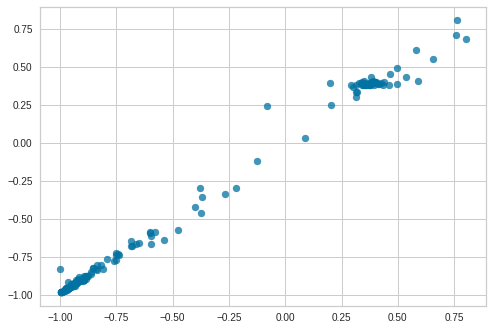

In [258]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_reg, X_train, y_train, X_test, y_test))


Residuals Plot


ValueError: The 'color' keyword argument must have one color per dataset, but 3 datasets and 1 colors were provided

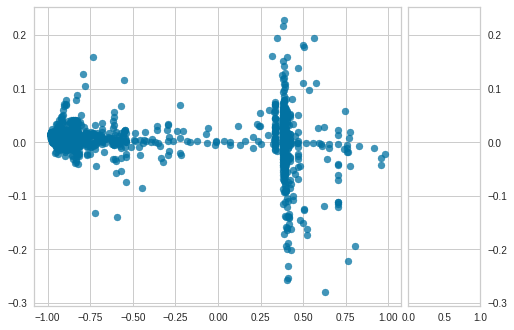

In [244]:
# Making the Residuals Plot
print("\nResiduals Plot")
print(residuals_plot(xgb_reg, X_train, y_train, X_test, y_test)) 

In [247]:
def save(nome, model, normalizer) 
    with open(f'models/normalizer_{nome}.pkl','wb') as f:
        pickle.dump(normalizer,f)
    with open(f'models/model_{nome}.pkl','wb') as f:
        pickle.dump(model,f)

In [248]:
testando=sc.fit_transform([[12313131,31234123,412312412,312312312]])
testando

array([[-1., -1., -1., -1.]])

In [249]:
xgb_reg.predict(testando)

array([[-0.98104846,  0.39051944, -0.98221195]], dtype=float32)